In [79]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
train_orig = pd.read_csv('./input/train.csv')
validate_orig = pd.read_csv('./input/test.csv')

In [81]:
# Based on code from here: https://www.kaggle.com/snmateen/simple-eda-feature-transformations/notebook

# set max rows and columns for pandas display
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows',1000)

In [82]:
# This code adapated from here: https://stackoverflow.com/questions/22470690/get-list-of-pandas-dataframe-columns-based-on-data-type

cols_obj = list(train_orig.select_dtypes(include=['object']).columns)
print(cols_obj)
len(cols_obj)

['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91', 'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98', 'cat99', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', 'cat108', 'cat109', 'cat110', 'cat111

116

In [83]:
# This code adapated from here: https://stackoverflow.com/questions/22470690/get-list-of-pandas-dataframe-columns-based-on-data-type

cols_nonobj = list(train_orig.select_dtypes(exclude=['object']).columns)
print(cols_nonobj)
len(cols_nonobj)

['id', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14', 'loss']


16

In [84]:
cols_cont_feat = cols_nonobj[1:-1]
print(cols_cont_feat)
len(cols_cont_feat)

['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14']


14

In [85]:
# check if any columns in one df but not the other
np.setxor1d(train_orig.columns, validate_orig.columns).tolist()

['loss']

In [86]:
# get count of continuous feature (non-obj columns) with missing values
print(len(train_orig.select_dtypes(exclude=['object']).columns[train_orig.select_dtypes(exclude=['object']).isnull().sum() > 0]))

0


In [87]:
train_loss = train_orig.loss
# slicing columns from 1 to -1 to leave out the id and loss features: (the first and last columns of the df)
train = train_orig.iloc[:, 1:-1]
# slicing columns from 1 to leave out the id feature (the first column of the df)
validate = validate_orig.iloc[:, 1:]

In [88]:
# Set values to NaN where a categorical value exists only in one df (train/validation)

# This code adapted from here: https://www.kaggle.com/iglovikov/xgb-1114
#    note: fixed bug in code based on use of nunique and refactored the set logic
#    comments in code are mine
#    prints values unique to one df col which have been set to NaN in the df in which they appear

# loop thru object columns (categorical features)
for column in list(train.select_dtypes(include=['object']).columns):
    # get the values that exist in only one set of unique values
    remove = set(train[column].unique()) ^ set(validate[column].unique())
    
    # check if the set of values to be removed is non-empty
    if len(remove) > 0:
        print(column, remove)
        
        # function to set a value to NaN in the case where it is unique to train or validate
        def filter_cat(x):
            if x in remove:
                return np.nan
            return x
        
        # apply the function to all values in the current column
        train[column] = train[column].apply(filter_cat, 1)
        validate[column] = validate[column].apply(filter_cat, 1)

cat89 {'I', 'F'}
cat90 {'G'}
cat92 {'G', 'E', 'F'}
cat96 {'H'}
cat99 {'U'}
cat101 {'U', 'N'}
cat102 {'J', 'H'}
cat103 {'M'}
cat105 {'R', 'S'}
cat106 {'Q'}
cat109 {'BT', 'BV', 'BF', 'BM', 'BY', 'CJ', 'AG', 'AD', 'BP', 'AK', 'J', 'B'}
cat110 {'BH', 'DV', 'H', 'BK', 'EN', 'EI', 'BN', 'BI', 'CB', 'EH', 'CA', 'AF', 'BD', 'AN'}
cat111 {'L', 'D'}
cat113 {'AA', 'R', 'BE', 'AC', 'T'}
cat114 {'X'}
cat116 {'AY', 'BF', 'DY', 'IB', 'AS', 'HS', 'MX', 'FS', 'IW', 'AB', 'W', 'HO', 'BL', 'JD', 'A', 'MB', 'GQ', 'MF', 'JT', 'IX', 'X', 'EQ', 'BN', 'DB', 'DQ', 'V', 'EX', 'FY', 'IK', 'BJ', 'KO', 'BR', 'LS', 'ER', 'BH', 'CC', 'LP', 'ET', 'HU', 'JS', 'EM', 'FO', 'AH', 'JN', 'C', 'MT', 'AT', 'AI', 'JI', 'AM', 'IS', 'EV', 'N', 'BI', 'AQ', 'AP', 'JO', 'BE', 'FN', 'IO', 'P'}


In [89]:
# save a reference to train before one-hot-encoding categorical columns
train_pre_dum = train

# one-hot-encode categorical features of train df (get_dummies ignores the floating point columns)
train = pd.get_dummies(train)

# one-hot-encode categorical features of validation df (get_dummies ignores the floating point columns)
validate = pd.get_dummies(validate)

In [90]:
# check if any columns in one df but not the other
#np.setxor1d(train.columns, validate.columns).tolist()
set(train.columns) ^ set(validate.columns)

set()

In [91]:
# create a lightGBM regressor object
lgbm_reg = lgb.LGBMRegressor(random_state=42)

In [92]:
# split data into train and test dfs
X_train, X_test, y_train, y_test = train_test_split(train, train_loss, test_size=.2, random_state=42)

In [93]:
# Fit the model using default parameters and predict the target (loss) values based on the model
#  then compare prediction with actual values and compute mean absolute error of residuals

# This is based on code from https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost

start=datetime.now()

lgbm_reg.fit(X_train, y_train)
        
stop=datetime.now()
print(stop-start)

y_pred=lgbm_reg.predict(X_test)
print('The mae of the model prediction is: ', mean_absolute_error(y_test, y_pred))

0:00:07.856895
The mae of the model prediction is:  1601.87628096


In [94]:
# Final parameters

param_grid = {
    'learning_rate': [1.2],
    'n_estimators': [110],
    'num_leaves': [50],
    'min_data_in_leaf': [500]
}

start=datetime.now()

lgbm_reg_best = GridSearchCV(lgbm_reg, param_grid)
lgbm_reg_best.fit(X_train, y_train)

stop=datetime.now()
print(stop-start)

y_pred=lgbm_reg_best.predict(X_test)
print('The mae of the model prediction is: ', mean_absolute_error(y_test, y_pred))

print('\nBest params:\n{}'.format(lgbm_reg_best.best_params_))

0:00:47.985074
The mae of the model prediction is:  1211.80536662

Best params:
{'learning_rate': 1.2, 'min_data_in_leaf': 500, 'n_estimators': 110, 'num_leaves': 50}


C:\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


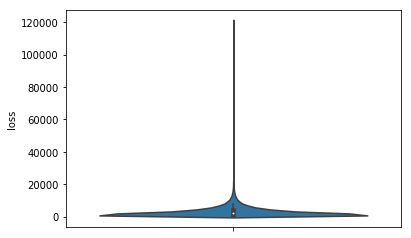

In [95]:
# Graph showing skew of loss data

# This code is adapted from here: https://www.kaggle.com/sharmasanthosh/exploratory-study-on-ml-algorithms/notebook

sns.violinplot(data=train_orig, y="loss")
plt.show()

In [96]:
# Adjust the highly-skewed loss data

#This code is from here: https://www.kaggle.com/iglovikov/xgb-1114
#  The shift value was discovered empirically
shift = 200
train_loss = np.log(train_orig["loss"] + shift)

C:\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


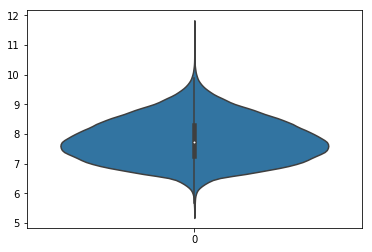

In [97]:
# graph the data after transform
sns.violinplot(data=train_loss)
plt.show()

In [98]:
# split data into train and test dfs
X_train, X_test, y_train, y_test = train_test_split(train, train_loss, test_size=.2, random_state=42)

In [99]:
# Final parameters

param_grid = {
    'learning_rate': [.2],
    'n_estimators': [300],
    'num_leaves': [10],
    'min_data_in_leaf': [300]
}

start=datetime.now()

lgbm_reg_best = GridSearchCV(lgbm_reg, param_grid)
lgbm_reg_best.fit(X_train, y_train)

stop=datetime.now()
print(stop-start)

y_pred=lgbm_reg_best.predict(X_test)

# adjust the predictions (due to adjustment of loss)
adj_y_test = np.exp(y_test) - shift
adj_y_pred = np.exp(y_pred) - shift

#print('The mae of the model prediction is: ', mean_absolute_error(y_test, y_pred))
print('The mae of the model prediction is: ', mean_absolute_error(adj_y_test, adj_y_pred))

print('\nBest params:\n{}'.format(lgbm_reg_best.best_params_))

0:00:51.085867
The mae of the model prediction is:  1146.1330493

Best params:
{'learning_rate': 0.2, 'min_data_in_leaf': 300, 'n_estimators': 300, 'num_leaves': 10}


In [100]:
# Remove highly correlated features

# Highly adapted from code here: https://www.kaggle.com/sharmasanthosh/exploratory-study-on-ml-algorithms/notebook
# Calculates pearson co-efficient for all combinations
train_corr = train_orig.iloc[:,1:-1].corr(method='pearson').stack()
# This was a helpful example of selecting every other row in df: https://stackoverflow.com/questions/37280681/reverse-even-rows-in-a-numpy-array-or-pandas-dataframe
train_corr[(train_corr < 1) & (train_corr >= .75)].sort_values(ascending=False).iloc[1::2]

cont11  cont12    0.994384
cont1   cont9     0.929912
cont10  cont6     0.883351
cont13  cont6     0.815091
cont1   cont10    0.808551
cont6   cont9     0.797544
cont10  cont9     0.785697
cont12  cont6     0.785144
cont11  cont6     0.773745
cont1   cont6     0.758315
dtype: float64

In [101]:
# Since: 
#     cont6 --> cont10, 13, 9, and 12
#     and cont9 & 10 --> cont1
#     and cont12 --> cont11
# Therefore:
#     Continuous features 9, 10, 11 & 12 are redundant with cont6

cols_cont_drop = ['cont1','cont9','cont10','cont11','cont12']

# This example was helpful here: https://stackoverflow.com/questions/13003051/how-do-i-exclude-a-few-columns-from-a-dataframe-plot
cols_remnant = train.columns.difference(cols_cont_drop)

cols_cont_feat = list(set(cols_cont_feat) - set(cols_cont_drop))

print(cols_cont_feat)

['cont3', 'cont7', 'cont4', 'cont2', 'cont5', 'cont14', 'cont8', 'cont13', 'cont6']


In [102]:
train = train[cols_remnant]
train[cols_cont_feat].describe()

,cont3,cont7,cont4,cont2,cont5,cont14,cont8,cont13,cont6
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,0.498918,0.484970,0.491812,0.507188,0.487428,0.495717,0.486437,0.493138,0.490945
std,0.202105,0.178450,0.211292,0.207202,0.209027,0.222488,0.199370,0.212777,0.205273
min,0.002634,0.069503,0.176921,0.001149,0.281143,0.179722,0.236880,0.000228,0.012683
25%,0.336963,0.350175,0.327354,0.358319,0.281143,0.294610,0.312800,0.315758,0.336105
50%,0.527991,0.438285,0.452887,0.555782,0.422268,0.407403,0.441060,0.363547,0.440945
75%,0.634224,0.591045,0.652072,0.681761,0.643315,0.724623,0.623580,0.689974,0.655021
max,0.944251,1.000000,0.954297,0.862654,0.983674,0.844848,0.980200,0.988494,0.997162


In [103]:
# split data into train and test dfs
X_train, X_test, y_train, y_test = train_test_split(train, train_loss, test_size=.2, random_state=42)

In [104]:
# Final parameters

param_grid = {
    'learning_rate': [.1],
    'n_estimators': [500],
    'num_leaves': [16],
    'min_data_in_leaf': [125]
}

start=datetime.now()

lgbm_reg_best = GridSearchCV(lgbm_reg, param_grid)
lgbm_reg_best.fit(X_train, y_train)

stop=datetime.now()
print(stop-start)

y_pred=lgbm_reg_best.predict(X_test)

# adjust the predictions (due to adjustment of loss)
adj_y_test = np.exp(y_test) - shift
adj_y_pred = np.exp(y_pred) - shift

#print('The mae of the model prediction is: ', mean_absolute_error(y_test, y_pred))
print('The mae of the model prediction is: ', mean_absolute_error(adj_y_test, adj_y_pred))

print('\nBest params:\n{}'.format(lgbm_reg_best.best_params_))

0:01:14.533219
The mae of the model prediction is:  1139.19598328

Best params:
{'learning_rate': 0.1, 'min_data_in_leaf': 125, 'n_estimators': 500, 'num_leaves': 16}


In [105]:
# Use 1.5 * IQR to define outliners

def get_outliers(series):
    Q1 = np.percentile(series, 25)
    Q3 = np.percentile(series, 75)
    IQR = Q3-Q1
    step = IQR * 1.5
    lower_bound = Q1 - step
    upper_bound = Q3 + step
    
    return series.apply(lambda x: not lower_bound <= x <= upper_bound)

outliers = pd.DataFrame()

for col in cols_cont_feat:
    col_outs = get_outliers(train[col])
    outliers = pd.concat([outliers, col_outs], axis=1)

total_count, _ = outliers.shape
outliers.describe()

,cont3,cont7,cont4,cont2,cont5,cont14,cont8,cont13,cont6
count,188318,188318,188318,188318,188318,188318,188318,188318,188318
unique,1,2,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False
freq,188318,185659,188318,188318,188318,188318,188318,188318,188318


In [106]:
# look at count of outliers and pct of total values

out_count = outliers.cont7.value_counts()[1]
print(out_count)
out_count / total_count

2659


0.014119733642031033

In [107]:
# Get median of cont7 values

cont7_median = train.cont7.median()
print(cont7_median)

# Create series with values from train.cont7 but replacing outliers with median
new_cont7 = (cont7_median - train.cont7) * outliers.cont7 + train.cont7

# Check that count of new values equal to median value is as expected (minus existing median values)
print(new_cont7[new_cont7==cont7_median].shape[0] - train.cont7[train.cont7==cont7_median].shape[0])

# Confirmed: count matches # of outliers found

# display new and old values if new value != old value
for ndx, valu in new_cont7.iteritems():
    if valu != train.cont7.iloc[ndx]:
        print(ndx, valu, train.cont7.iloc[ndx])

# Confirmed: old values look like outliers and new value is the median value

# Replace cont7 in train data set with new values
train.cont7 = new_cont7


0.43828500000000004
2659
77 0.43828500000000004 0.985762
106 0.43828500000000004 0.982302
179 0.43828500000000004 0.993938
275 0.43828500000000004 0.95483
301 0.43828500000000004 0.997761
327 0.43828500000000004 0.98473
369 0.43828500000000004 0.953884
406 0.43828500000000004 0.965359
490 0.43828500000000004 0.999259
503 0.43828500000000004 0.979276
520 0.43828500000000004 0.970764
541 0.43828500000000004 0.989659
731 0.43828500000000004 0.95483
791 0.43828500000000004 0.99792
879 0.43828500000000004 0.972119
922 0.43828500000000004 0.999708
924 0.43828500000000004 0.952897
989 0.43828500000000004 0.986583
1031 0.43828500000000004 0.978156
1053 0.43828500000000004 0.982302
1144 0.43828500000000004 0.997098
1301 0.43828500000000004 0.99884
1389 0.43828500000000004 0.966972
1536 0.43828500000000004 0.964994
1543 0.43828500000000004 0.972119
1624 0.43828500000000004 0.960335
1632 0.43828500000000004 0.977482
1719 0.43828500000000004 0.99433
1737 0.43828500000000004 0.997734
1776 0.4382850

38893 0.43828500000000004 0.967843
38968 0.43828500000000004 0.985574
39054 0.43828500000000004 0.997984
39185 0.43828500000000004 0.989014
39256 0.43828500000000004 0.982293
39372 0.43828500000000004 0.970127
39411 0.43828500000000004 0.971222
39483 0.43828500000000004 0.970369
39540 0.43828500000000004 0.998292
39563 0.43828500000000004 0.970369
39570 0.43828500000000004 0.973566
39579 0.43828500000000004 0.991866
39696 0.43828500000000004 0.979693
39811 0.43828500000000004 0.954936
39873 0.43828500000000004 0.976002
39892 0.43828500000000004 0.971264
39953 0.43828500000000004 0.956727
39999 0.43828500000000004 0.973705
40090 0.43828500000000004 0.989409
40095 0.43828500000000004 0.969197
40123 0.43828500000000004 0.989659
40141 0.43828500000000004 0.987553
40160 0.43828500000000004 0.953622
40246 0.43828500000000004 0.96192
40418 0.43828500000000004 0.958451
40486 0.43828500000000004 0.986583
40514 0.43828500000000004 0.970749
40530 0.43828500000000004 0.957738
40604 0.4382850000000

61150 0.43828500000000004 0.998292
61184 0.43828500000000004 0.986771
61198 0.43828500000000004 0.987184
61220 0.43828500000000004 0.997339
61467 0.43828500000000004 0.972119
61483 0.43828500000000004 0.993009
61522 0.43828500000000004 0.997734
61582 0.43828500000000004 0.989659
61772 0.43828500000000004 0.965044
61900 0.43828500000000004 0.968467
61909 0.43828500000000004 0.958451
61914 0.43828500000000004 0.982293
62058 0.43828500000000004 0.984558
62174 0.43828500000000004 0.986583
62349 0.43828500000000004 0.982851
62426 0.43828500000000004 0.982302
62514 0.43828500000000004 0.991349
62537 0.43828500000000004 0.99837
62562 0.43828500000000004 0.969344
62605 0.43828500000000004 0.990736
62636 0.43828500000000004 0.993114
62653 0.43828500000000004 0.970749
62687 0.43828500000000004 0.996334
62865 0.43828500000000004 0.987184
62889 0.43828500000000004 0.987033
62967 0.43828500000000004 0.965011
62976 0.43828500000000004 0.980539
62990 0.43828500000000004 0.965786
63034 0.4382850000000

86269 0.43828500000000004 0.974758
86413 0.43828500000000004 0.989424
86504 0.43828500000000004 0.993938
86515 0.43828500000000004 0.991579
86564 0.43828500000000004 0.96192
86625 0.43828500000000004 0.973705
86654 0.43828500000000004 0.993009
86658 0.43828500000000004 0.972806
86804 0.43828500000000004 0.987553
86857 0.43828500000000004 0.970749
86869 0.43828500000000004 0.972119
86877 0.43828500000000004 0.955799
86933 0.43828500000000004 0.987184
87069 0.43828500000000004 0.997051
87117 0.43828500000000004 0.991562
87184 0.43828500000000004 0.983464
87246 0.43828500000000004 0.999493
87294 0.43828500000000004 0.964541
87391 0.43828500000000004 0.96192
87441 0.43828500000000004 0.99871
87725 0.43828500000000004 0.989659
87768 0.43828500000000004 0.997553
87851 0.43828500000000004 0.952519
87935 0.43828500000000004 0.988151
88025 0.43828500000000004 0.977482
88232 0.43828500000000004 0.996718
88294 0.43828500000000004 0.985728
88338 0.43828500000000004 0.96192
88521 0.4382850000000000

111486 0.43828500000000004 0.971222
111668 0.43828500000000004 0.969344
111675 0.43828500000000004 0.957937
111683 0.43828500000000004 0.998444
111765 0.43828500000000004 0.960541
111834 0.43828500000000004 0.99837
111863 0.43828500000000004 0.996718
111931 0.43828500000000004 0.989948
111975 0.43828500000000004 0.974514
111999 0.43828500000000004 0.95519
112103 0.43828500000000004 0.962637
112120 0.43828500000000004 0.997258
112129 0.43828500000000004 0.972557
112182 0.43828500000000004 0.994097
112200 0.43828500000000004 0.99837
112277 0.43828500000000004 0.99462
112528 0.43828500000000004 0.964304
112628 0.43828500000000004 0.964994
112685 0.43828500000000004 0.992531
112689 0.43828500000000004 0.982302
112783 0.43828500000000004 0.962637
112819 0.43828500000000004 0.989659
112838 0.43828500000000004 0.962637
112907 0.43828500000000004 0.983464
113022 0.43828500000000004 0.981023
113072 0.43828500000000004 0.95519
113176 0.43828500000000004 1.0
113191 0.43828500000000004 0.971264
11

133026 0.43828500000000004 0.969344
133202 0.43828500000000004 0.98473
133242 0.43828500000000004 0.994421
133264 0.43828500000000004 0.997847
133295 0.43828500000000004 0.95519
133324 0.43828500000000004 0.95519
133527 0.43828500000000004 0.992804
133537 0.43828500000000004 0.970369
133636 0.43828500000000004 0.997734
133665 0.43828500000000004 0.991579
133736 0.43828500000000004 0.95519
133797 0.43828500000000004 0.991302
133840 0.43828500000000004 0.984377
133846 0.43828500000000004 0.994883
133886 0.43828500000000004 0.965011
133974 0.43828500000000004 0.999021
134064 0.43828500000000004 0.997693
134118 0.43828500000000004 0.991349
134151 0.43828500000000004 0.997339
134264 0.43828500000000004 0.983584
134307 0.43828500000000004 0.960071
134325 0.43828500000000004 0.95519
134355 0.43828500000000004 0.965359
134422 0.43828500000000004 0.978103
134435 0.43828500000000004 0.997553
134436 0.43828500000000004 0.985269
134462 0.43828500000000004 0.988928
134473 0.43828500000000004 0.9897

156104 0.43828500000000004 0.989659
156260 0.43828500000000004 0.997734
156273 0.43828500000000004 0.972596
156376 0.43828500000000004 0.95519
156401 0.43828500000000004 0.953884
156447 0.43828500000000004 0.989424
156521 0.43828500000000004 0.95519
156595 0.43828500000000004 0.986386
156614 0.43828500000000004 0.989003
156630 0.43828500000000004 0.970369
156791 0.43828500000000004 0.986681
156810 0.43828500000000004 0.965011
156866 0.43828500000000004 0.998678
156919 0.43828500000000004 0.989659
156922 0.43828500000000004 0.953622
157007 0.43828500000000004 0.994545
157052 0.43828500000000004 0.980642
157065 0.43828500000000004 0.988029
157219 0.43828500000000004 0.992198
157237 0.43828500000000004 0.979956
157428 0.43828500000000004 0.99837
157477 0.43828500000000004 0.980642
157629 0.43828500000000004 0.982851
157649 0.43828500000000004 0.970917
157723 0.43828500000000004 0.985728
157754 0.43828500000000004 0.991667
157770 0.43828500000000004 0.998101
157846 0.43828500000000004 0.98

In [108]:
# split data into train and test dfs
X_train, X_test, y_train, y_test = train_test_split(train, train_loss, test_size=.2, random_state=42)

In [109]:
start=datetime.now()
lgbm_reg_best.fit(X_train, y_train)
stop=datetime.now()
print(stop-start)

y_pred=lgbm_reg_best.predict(X_test)

# adjust the predictions (due to adjustment of loss)
adj_y_test = np.exp(y_test) - shift
adj_y_pred = np.exp(y_pred) - shift

#print('The mae of the model prediction is: ', mean_absolute_error(y_test, y_pred))
print('The mae of the model prediction is: ', mean_absolute_error(adj_y_test, adj_y_pred))

print('\nBest params:\n{}'.format(lgbm_reg_best.best_params_))

0:01:14.141183
The mae of the model prediction is:  1140.23833551

Best params:
{'learning_rate': 0.1, 'min_data_in_leaf': 125, 'n_estimators': 500, 'num_leaves': 16}


In [110]:
# no improvement - this transformation not included in final model

In [111]:
# try removing outlier rows

out_cont7_ndx = outliers[outliers.cont7 == True].index

train = train.drop(out_cont7_ndx)
train_loss = train_loss.drop(out_cont7_ndx)
    

In [112]:
print(train.shape[0], train_loss.shape[0])

185659 185659


In [113]:
# split data into train and test dfs
X_train, X_test, y_train, y_test = train_test_split(train, train_loss, test_size=.2, random_state=42)

In [114]:
start=datetime.now()
lgbm_reg_best.fit(X_train, y_train)
stop=datetime.now()
print(stop-start)

y_pred=lgbm_reg_best.predict(X_test)

# adjust the predictions (due to adjustment of loss)
adj_y_test = np.exp(y_test) - shift
adj_y_pred = np.exp(y_pred) - shift

#print('The mae of the model prediction is: ', mean_absolute_error(y_test, y_pred))
print('The mae of the model prediction is: ', mean_absolute_error(adj_y_test, adj_y_pred))

print('\nBest params:\n{}'.format(lgbm_reg_best.best_params_))

0:01:13.514357
The mae of the model prediction is:  1128.01689189

Best params:
{'learning_rate': 0.1, 'min_data_in_leaf': 125, 'n_estimators': 500, 'num_leaves': 16}


In [115]:
# examine skew of remaining continuous features
# Code adapated from here: https://www.kaggle.com/snmateen/simple-eda-feature-transformations/notebook

sku = train[cols_cont_feat].skew()
sku[abs(sku) > .7]

cont7    0.743485
dtype: float64

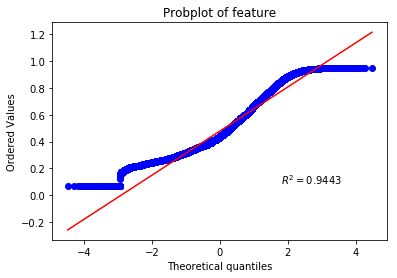

In [116]:
# plot deviation from normal distribution
# Code adapated from here: https://www.kaggle.com/snmateen/simple-eda-feature-transformations/notebook

ax=plt.gca()
stats.probplot(train.cont7, dist=stats.norm, plot=ax, rvalue=True)
ax.set_title('Probplot of feature')
plt.show()

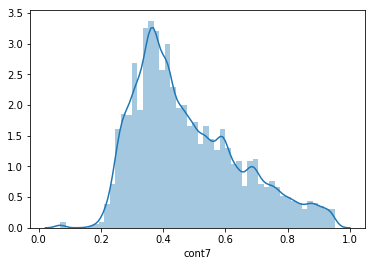

In [117]:
# Code adapated from here: https://www.kaggle.com/snmateen/simple-eda-feature-transformations/notebook

sns.distplot(train.cont7, bins=50)
plt.show()

In [118]:
# use boxcox to transform highly-skewed feature, cont7 - that is, normalize it
# Based on example code from here: https://www.kaggle.com/snmateen/simple-eda-feature-transformations/notebook

xcf, _ = stats.boxcox(train.cont7)

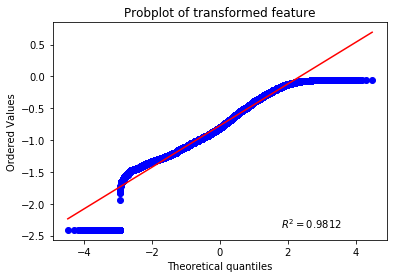

In [119]:
# show difference from normal distribution of transformed feature
# Code adapated from here: https://www.kaggle.com/snmateen/simple-eda-feature-transformations/notebook

ax=plt.gca()
stats.probplot(xcf, dist=stats.norm, plot=ax, rvalue=True)
ax.set_title('Probplot of transformed feature')
plt.show()

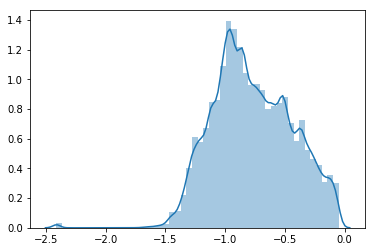

In [120]:
# Code adapated from here: https://www.kaggle.com/snmateen/simple-eda-feature-transformations/notebook

sns.distplot(xcf, bins=50)
plt.show()

In [121]:
# make a new df with the transformed feature
train.cont7 = xcf

In [122]:
train[cols_cont_feat].describe()

,cont3,cont7,cont4,cont2,cont5,cont14,cont8,cont13,cont6
count,185659.000000,185659.000000,185659.000000,185659.000000,185659.000000,185659.000000,185659.000000,185659.000000,185659.000000
mean,0.497367,-0.771165,0.494039,0.506920,0.489335,0.495556,0.487035,0.493952,0.487960
std,0.201635,0.330414,0.211590,0.207063,0.209507,0.222310,0.200028,0.212223,0.204323
min,0.002634,-2.411702,0.176921,0.001149,0.281143,0.179722,0.236880,0.000228,0.012683
25%,0.336963,-1.008256,0.327354,0.358319,0.281143,0.294644,0.312800,0.315758,0.334532
50%,0.527991,-0.805101,0.452887,0.555782,0.422268,0.408085,0.441060,0.363547,0.438917
75%,0.634224,-0.522034,0.670373,0.681761,0.643315,0.724558,0.623580,0.689974,0.648884
max,0.944251,-0.049047,0.954297,0.862654,0.983674,0.844848,0.980200,0.988494,0.997162


In [123]:
# split data into train and test dfs
X_train, X_test, y_train, y_test = train_test_split(train, train_loss, test_size=.2, random_state=42)

In [124]:
# Final parameters

param_grid = {
    'learning_rate': [.2],
    'n_estimators': [500],
    'num_leaves': [12],
    'min_data_in_leaf': [375]
}

start=datetime.now()

lgbm_reg_best = GridSearchCV(lgbm_reg, param_grid)
lgbm_reg_best.fit(X_train, y_train)

stop=datetime.now()
print(stop-start)

y_pred=lgbm_reg_best.predict(X_test)

adj_y_test = np.exp(y_test) - shift
adj_y_pred = np.exp(y_pred) - shift

#print('The mae of the model prediction is: ', mean_absolute_error(y_test, y_pred))
print('The mae of the model prediction is: ', mean_absolute_error(adj_y_test, adj_y_pred))

print('\nBest params:\n{}'.format(lgbm_reg_best.best_params_))

0:01:05.152434
The mae of the model prediction is:  1126.7991885

Best params:
{'learning_rate': 0.2, 'min_data_in_leaf': 375, 'n_estimators': 500, 'num_leaves': 12}


In [125]:
# *****
# This was the final model (tried PCA below but it didn't help)
# The mae of the model prediction was:  1126.7991885
# *****

In [126]:
# Try PCA on remaining continuous features
# This example was helpful: https://www.kaggle.com/bertcarremans/reducing-number-of-numerical-features-with-pca


# scale cont7 (boxcox changed scale - it was 0-1 like the other cont features)
# Removing because cont. features are already scaled
from sklearn.preprocessing import minmax_scale

minmax_scale(xcf, feature_range=(0,1), copy=False)

pca = PCA(n_components=None, random_state=42)

start=datetime.now()
train_pca = pca.fit_transform(train[cols_cont_feat])
stop=datetime.now()
print(stop-start)

0:00:00.093246


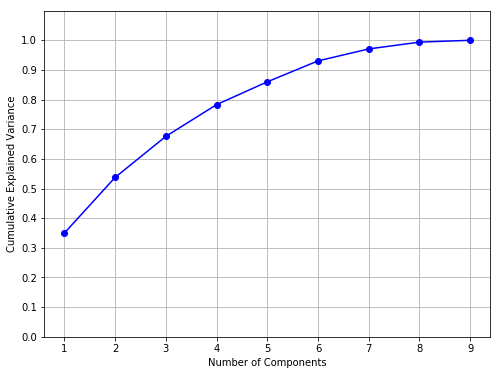

In [127]:
# graph showing amount of variance explained 
# code adapted from here: https://www.kaggle.com/bertcarremans/reducing-number-of-numerical-features-with-pca 

varExp = pca.explained_variance_ratio_

# based on example from here: https://stackoverflow.com/questions/15889131/how-to-find-the-cumulative-sum-of-numbers-in-a-list 
vey = np.cumsum(varExp)
oy = [x for x in range(1, len(varExp)+1)]

plt.subplots(figsize=(8, 6))
plt.grid(True)
plt.plot(oy, vey, 'bo-')
plt.ylabel('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylim([0.0, 1.1])
plt.xticks(oy)
plt.yticks(np.arange(0.0, 1.1, 0.10))
plt.show()

In [128]:
# Run PCA on train dataset with 7 components, which explain 95% of variance
pca = PCA(n_components=7, random_state=42)

start=datetime.now()
train_pca_cont_feat = pd.DataFrame(pca.fit_transform(train[cols_cont_feat]), columns=['pca_cont1','pca_cont2','pca_cont3','pca_cont4','pca_cont5','pca_cont6','pca_cont7'])
stop=datetime.now()
print(stop-start)

0:00:00.365974


In [129]:
train_pca_cont_feat.describe()

,pca_cont1,pca_cont2,pca_cont3,pca_cont4,pca_cont5,pca_cont6,pca_cont7
count,1.856590e+05,1.856590e+05,1.856590e+05,1.856590e+05,1.856590e+05,1.856590e+05,1.856590e+05
mean,7.563682e-17,1.708279e-17,-1.190406e-16,4.173913e-17,8.343222e-17,-7.840336e-17,1.635443e-16
std,4.000464e-01,2.930905e-01,2.517791e-01,2.212319e-01,1.876488e-01,1.797001e-01,1.359113e-01
min,-1.069253e+00,-9.549809e-01,-7.993702e-01,-4.208201e-01,-5.476038e-01,-7.793232e-01,-5.329009e-01
25%,-3.059459e-01,-1.742150e-01,-1.827656e-01,-1.989462e-01,-1.497158e-01,-1.163898e-01,-9.210513e-02
50%,1.876178e-02,1.308574e-02,-2.690152e-03,-7.029353e-02,6.592054e-03,8.509964e-03,-2.387026e-03
75%,3.318876e-01,2.292985e-01,1.820982e-01,2.267421e-01,1.425138e-01,1.211884e-01,8.702271e-02
max,1.723468e+00,1.120669e+00,8.100631e-01,4.422685e-01,8.528357e-01,9.057689e-01,5.700605e-01


In [130]:
train_pca_cont_feat.reset_index(drop=True, inplace=True)
train.reset_index(drop=True, inplace=True)
train_pca = pd.concat([train_pca_cont_feat, train[train.columns.difference(cols_cont_feat)]], axis=1)

In [131]:
# confirm shape of new df
print(train_pca.shape[0], train.shape[0])

185659 185659


In [132]:
# split data into train and test dfs
X_train, X_test, y_train, y_test = train_test_split(train_pca, train_loss, test_size=.2, random_state=42)

In [134]:
lgbm_reg_pca = lgb.LGBMRegressor(random_state=42)

# Final parameters
param_grid = {
    'learning_rate': [.2],
    'n_estimators': [500],
    'num_leaves': [12],
    'min_data_in_leaf': [375]
}

start=datetime.now()

lgbm_reg_best_pca = GridSearchCV(lgbm_reg_pca, param_grid)
lgbm_reg_best_pca.fit(X_train, y_train)

stop=datetime.now()
print(stop-start)

y_pred=lgbm_reg_best_pca.predict(X_test)

# adjust the predictions (due to adjustment of loss)
adj_y_test = np.exp(y_test) - shift
adj_y_pred = np.exp(y_pred) - shift

#print('The mae of the model prediction is: ', mean_absolute_error(y_test, y_pred))
print('The mae of the model prediction is: ', mean_absolute_error(adj_y_test, adj_y_pred))

print('\nBest params:\n{}'.format(lgbm_reg_best_pca.best_params_))

0:01:18.619059
The mae of the model prediction is:  1134.33426738

Best params:
{'learning_rate': 0.2, 'min_data_in_leaf': 375, 'n_estimators': 500, 'num_leaves': 12}


In [135]:
# 
# No improvement from PCA
#

In [136]:
# Preprocess validation features (from test.csv file) to conform with sucessful feature preprocessing of train data:

#   Drop features highly correlated with cont6
validate = validate[validate.columns.difference(cols_cont_drop)]

#   Box-cox transform cont7 feature
validate.cont7, _ = stats.boxcox(validate.cont7)

#   Run model on processed validation data
y_pred = lgbm_reg_best.predict(validate)

#   Transform loss predictions back to original feature space:
adj_y_pred = np.exp(y_pred) - shift

In [137]:
val_pred = pd.DataFrame({'id': validate_orig.id, 'loss': adj_y_pred})
val_pred.describe()

,id,loss
count,125546.000000,125546.000000
mean,294067.153442,2668.323054
std,170098.335649,1957.193377
min,4.000000,357.507791
25%,146414.250000,1408.635515
50%,294306.000000,2056.830177
75%,441800.000000,3218.161413
max,587634.000000,25161.196432


In [ ]:
val_pred.to_csv(".\output\submit2.csv", index=False, float_format="%.2f")
# score from Kaggle: 1131.90796
# rank: between entries 1350 and 1351

In [ ]:
# this code is based on the example in the sklearn documentation

from sklearn.neighbors import KNeighborsRegressor

knnr = KNeighborsRegressor()

start=datetime.now()
knnr.fit(X_train, y_train)
stop=datetime.now()
print(stop-start)

start=datetime.now()
y_pred = knnr.predict(X_test)
stop=datetime.now()
print(stop-start)

adj_y_test = np.exp(y_test) - shift
adj_y_pred = np.exp(y_pred) - shift

print('The mae of the model prediction is: ', mean_absolute_error(adj_y_test, adj_y_pred))

print('\nBest params:\n{}'.format(knnr.get_params()))

0:00:42.683519


In [ ]:
# this code is based on the example in the sklearn documentation

from sklearn.linear_model import ElasticNetCV

enr = ElasticNetCV(cv=5, max_iter=4000, random_state=42)

start=datetime.now()
enr.fit(X_train, y_train)
stop=datetime.now()
print(stop-start)

start=datetime.now()
y_pred = enr.predict(X_test)
stop=datetime.now()
print(stop-start)

adj_y_test = np.exp(y_test) - shift
adj_y_pred = np.exp(y_pred) - shift

print('The mae of the model prediction is: ', mean_absolute_error(adj_y_test, adj_y_pred))

print('\nParameters:\n{}'.format(enr.get_params()))